In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageStat

import json
import numpy as np
import cv2
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imutils import paths
import argparse
import imutils


from os import listdir
from os.path import isfile, join

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import json
import numpy as np
import cv2
from matplotlib import pyplot

#python -m pip install -U scikit-image
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV
#from skimage.io import imread
from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

dir = "food-101/food-101/images/"

def imOpen(path):
    imPath = dir + path
    img = mpimg.imread(imPath)
    return img

In [3]:


# def brightness(im_file):
#    im = Image.open(im_file).convert('L')
#    stat = ImageStat.Stat(im)
#    im.close
#    return stat.rms[0]

# def image_to_feature_vector(image, size=(256, 256)):
#     # resize the image to a fixed size, then flatten the image into
#     # a list of raw pixel intensities
#     return cv2.resize(image, size).flatten()

# def extract_color_histogram(image, bins=(8, 8, 8)):
#     # extract a 3D color histogram from the HSV color space using
#     # the supplied number of `bins` per channel
#     hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#     hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
#         [0, 180, 0, 256, 0, 256])
#     # handle normalizing the histogram if we are using OpenCV 2.4.X
#     if imutils.is_cv2():
#         hist = cv2.normalize(hist)
#     # otherwise, perform "in place" normalization in OpenCV 3 (I
#     # personally hate the way this is done
#     else:
#         cv2.normalize(hist, hist)
#     # return the flattened histogram as the feature vector
#     return hist.flatten()

In [4]:
# categories = open('food-101/food-101/meta/classes.txt').read().split()

# test = json.load(open('food-101/food-101/meta/test.json'))
# train = json.load(open('food-101/food-101/meta/train.json'))

# count_test = np.array(list(test.values()))
# print('Number of Test Images:', count_test.shape[0] * count_test.shape[1])

# count_train = np.array(list(train.values()))
# print('Number of Train Images:', count_train.shape[0] * count_train.shape[1])

# whole = {}
# for key in test.keys():
#     whole[key] = test[key]
#     whole[key] += train[key]

# count_whole = np.array(list(whole.values()))
# print('Total Number of Images:', count_whole.shape[0] * count_whole.shape[1])

# print('Number of categories:', len(categories))
# print('Number of photos per category:', len(whole['apple_pie']))
# print('List of categories:', categories)

# plt.imshow(imOpen(train[categories[0]][0] + '.jpg'));

# print('\nTrain Dataset')
# print('Example Keys:', list(train.keys())[:5])
# print('Example Values:', train['churros'][:5])
# print('\nTest Dataset')
# print('Example Keys:', list(test.keys())[:5])
# print('Example Values:', test['churros'][:5])

In [5]:
# #Select number of images to be random sampled
# randomSampleCount = 50

# # random.seed(255)
# sequence = [i for i in range(1001)]
# randList = random.sample(sequence, randomSampleCount)

# randomSampled = []
# scaleddir = 'food-101/food-101/imagesScaled/'
# for cat in categories:
#     directory = scaleddir + cat
#     path = os.listdir(directory)
#     index = 0
#     imagesToBeSampled = []
#     for images in path:
#         index = index + 1
#         if(index in randList):
#             imagesToBeSampled.append(images)
#     randomSampled.append(imagesToBeSampled)
# print(randomSampled[0][:25])

# # 50 random images from each of the 101 categories

### KNN
In this section we will detail our process for using KNN to attempt to perform classification on a subset of food images.

Similarly to our SVM model:

- We only used 5 food categories, each containint 1000 images where we created a 70/30 training/test split.
- Each image was of size 50x50 as KNN does not do well with high dimensional data and the original 250x250 (plus 3 color channels) would result in 187,500 features.
- Each category was randomly sampled from the full set of 101 categories.
- This model uses the random seed 118 to reproduce results.
- While the KNN training runtime was significantly faster than that of SVM, we still chose to train the model on only five categories to maintain consistency between models and for ease of comparison later on.

Below is the code that randomly samples 5 categories from the entire list of food categories and processes the images into a dataframe. This dataframe of image data is then split into train and test sets to be used in the KNN model.

In [6]:
random.seed(118)
categories = open('food-101/food-101/meta/classes.txt').read().split()
test = json.load(open('food-101/food-101/meta/test.json'))
train = json.load(open('food-101/food-101/meta/train.json'))

# KNN Work
flat = []
images2 = []
# Resized array ***CRITICAL USE RESIZED ARRAY
scaleddir = 'food-101/food-101/imagesScaled/'

# This gets all images and puts them into a dataframe
# DESIGN NOTES
# Changes image size to 50x50 due to processign speed.
# KNN does not work well with high dimensional data so, 250x250 is too much
index = 0
for cat in random.sample(categories, 5): #categories[:50]:
    print(f'processing category {index}: {cat}...')
    directory = scaleddir + cat    
    # path = randomSampled[index]
    path = [f for f in listdir(directory) if isfile(join(directory, f))]
    index = index + 1
    for images in path:
        toArr = imread(os.path.join(directory, images))
        img_resized = resize(toArr, (50, 50, 3))
        flat.append(img_resized.flatten())
        images2.append(cat)

print('converting image data into dataframe...')
df = pd.DataFrame(np.array(flat))
print('appending category name to dataframe...')
df['Target'] = np.array(images2)

#Here we create our test to data split, Default is 30
ts = .30
rs = 45
x = df.iloc[:, :-1]
y = df.iloc[:, -1]
print('Splitting into train and test sets...\n')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=ts, random_state=rs, stratify=y)

print("Number of training data: " + str(len(x_train)))
print("Number of testing data: " + str(len(x_test)))



processing category 0: spaghetti_carbonara...
processing category 1: pulled_pork_sandwich...
processing category 2: churros...
processing category 3: foie_gras...
processing category 4: cannoli...
converting image data into dataframe...
appending category name to dataframe...
Splitting into train and test sets...

Number of training data: 3500
Number of testing data: 1500


In [7]:
# for food in ['spaghetti_carbonara', 'pulled_pork_sandwich', 'churros', 'foie_gras', 'cannoli']:
#     print(f'This is an example of {food} training image')
#     plt.imshow(imOpen(train[food][0]+'.jpg'))
#     plt.show()

For our KNN classifier, we opted to search through a range of k from 1 to 20 with a step size of 2, resulting in 10 separate models, each with 4 folds.

In [8]:
knn = KNeighborsClassifier()
k_range = list(range(1, 20, 2))
param_grid = dict(n_neighbors = k_range)

grid = GridSearchCV(knn, param_grid, cv=4, scoring='accuracy', return_train_score=True, verbose=1)
grid_search = grid.fit(x_train, y_train)

print('\nThe best params are:', grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("KNN Training Acccuracy: {:.2f}%".format(accuracy))

knn2 = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn2.fit(x, y)
y_test_hat=knn2.predict(x_test)
train_pred = knn2.predict(x_train)
test_accuracy=np.mean(y_test_hat == y_test)*100 # accuracy_score(y_test,y_test_hat)*100
print("KNN Testing Accuracy: {:.2f}%".format(test_accuracy))

Fitting 4 folds for each of 10 candidates, totalling 40 fits

The best params are: {'n_neighbors': 5}
KNN Training Acccuracy: 29.94%
KNN Testing Accuracy: 47.80%


From this, we can see that our best performing KNN model had 5 `n_neighbors` and achieved an accuracy of around 47%. What's interesting is that the training accuracy is *lower* than the testing accuracy at around 29%. Both of these seem to be at least better than random chance, where we would expect to see roughly 20% accuracy for five categories (1 / # of categories).

Plotting the predictions for the training and test sets alongside the actual data may give us an insight into what is going on.

In [9]:
# results = pd.DataFrame({'test_predicted': y_test_hat, 'actual':y_test})
# results2 = pd.DataFrame({'train_predicted': train_pred, 'actual':y_train})
# fig, axes = plt.subplots(2, 2, figsize=(10,10), sharey=True, sharex=True)
# fig.suptitle('Category Prediction Counts vs. Actual Counts')
# sns.countplot(data=results2, y='train_predicted', ax=axes[0,0])
# sns.countplot(data=results2, y='actual', ax=axes[0,1])
# sns.countplot(data=results, y='test_predicted', ax=axes[1,0]);
# sns.countplot(data=results, y='actual', ax=axes[1,1]);

Training Accuracy
                       precision    recall  f1-score   support

             cannoli       0.59      0.47      0.52       867
             churros       0.22      0.74      0.34       213
           foie_gras       0.48      0.55      0.51       607
pulled_pork_sandwich       0.16      0.77      0.26       143
 spaghetti_carbonara       0.91      0.38      0.54      1670

            accuracy                           0.47      3500
           macro avg       0.47      0.58      0.44      3500
        weighted avg       0.68      0.47      0.51      3500


Testing Accuracy
                       precision    recall  f1-score   support

             cannoli       0.65      0.46      0.54       422
             churros       0.20      0.62      0.30        96
           foie_gras       0.47      0.60      0.53       235
pulled_pork_sandwich       0.16      0.84      0.27        57
 spaghetti_carbonara       0.91      0.39      0.55       690

            accuracy       

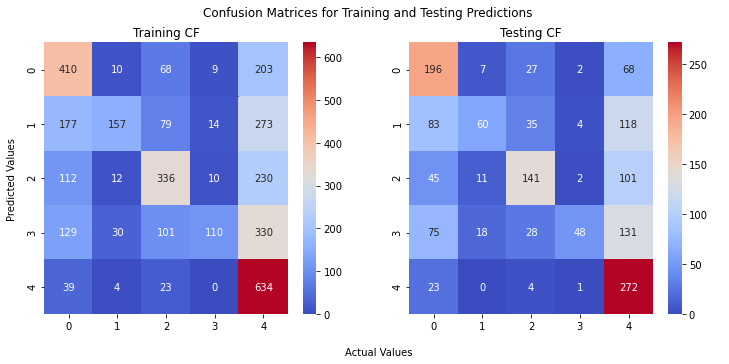

In [10]:
print('Training Accuracy\n', classification_report(train_pred, y_train))
print('\nTesting Accuracy\n', classification_report(y_test_hat, y_test))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Confusion Matrices for Training and Testing Predictions')

cf_matrix = confusion_matrix(y_train, train_pred)
sns.heatmap(cf_matrix, fmt="d", annot=True, cmap='coolwarm', ax=axes[0])
axes[0].title.set_text('Training CF')

cf_matrix = confusion_matrix(y_test, y_test_hat)
sns.heatmap(cf_matrix, fmt="d", annot=True, cmap='coolwarm', ax=axes[1])
axes[1].title.set_text('Testing CF')

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("\nActual Values")
plt.ylabel("Predicted Values");

<!-- We can see that, in both the training and testing datasets, the KNN model usually fails to predict one or two of the categories, leading to the majority of predictions being one of the three remaining categories. -->

We can see that, in both the training and testing datasets, the KNN model usually prefers to predict around three of the five categories, leaving two categories with fewer predictions than the rest. This can be determined by the low precision scores for the `churros`, `foie_gras`, and `pulled_pork_sandwich` categories, indicating a higher rate of false positives predictions.

But is this trend the same across different groups of categories? Since we randomly chose 5 categories to train the KNN model on, perhaps we randomly selected a particularly difficult group of categories to train on. We can run many iterations of the above code and see if they have similar relationships between training and testing accuracies.

In [11]:
def createRandomData():
    flat = []
    images2 = []
    scaleddir = 'food-101/food-101/imagesScaled/'

    index = 0
    cat_list = random.sample(categories, 5)
    for cat in cat_list: 
        directory = scaleddir + cat    
        path = [f for f in listdir(directory) if isfile(join(directory, f))]
        index = index + 1
        for images in path:
            toArr = imread(os.path.join(directory, images))
            img_resized = resize(toArr, (50, 50, 3)) 
            flat.append(img_resized.flatten())
            images2.append(cat)

    df = pd.DataFrame(np.array(flat))
    df['Target'] = np.array(images2)

    ts = .30
    rs = 45
    x = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=ts, random_state=rs, stratify=y)

    return x_train, x_test, y_train, y_test, x, y, cat_list

In [12]:
def runKNN(x_train, x_test, y_train, y_test, x, y, cat_list):
    
    knn = KNeighborsClassifier()
    k_range = list(range(1,21, 2))
    param_grid = dict(n_neighbors = k_range)

    grid = GridSearchCV(knn, param_grid, cv=4, scoring='accuracy')
    grid_search = grid.fit(x_train, y_train)

    best_param = grid_search.best_params_

    knn2 = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
    knn2.fit(x, y)
    y_test_hat = knn2.predict(x_test) 
    y_train_hat = knn2.predict(x_train)
    train_accuracy = np.mean(y_train_hat == y_train)*100
    test_accuracy = np.mean(y_test_hat == y_test)*100 
    multi_confusion_matrix = multilabel_confusion_matrix(y_test, y_test_hat, labels=cat_list)
    full_cfmatrix = confusion_matrix(y_test, y_test_hat)
    
    return best_param, train_accuracy, test_accuracy, knn2, multi_confusion_matrix, full_cfmatrix

In [13]:
# # SAVED IN PICKLE
# accuracies = []
# train_accuracies = []
# params = []
# cats = []
# c_matrices = []
# full_cfmatrices = []

# for i in range(100):
#     print(f'Processing Epoch {i}...')
#     x_train, x_test, y_train, y_test, x, y, cat_list = createRandomData()
#     cats.append(cat_list)
#     best_param, train_accuracy, test_accuracy, knn, confusion_matrices, full_cfmatrix = runKNN(x_train, x_test, y_train, y_test, x, y, cat_list)
#     full_cfmatrices.append(full_cfmatrix)
#     c_matrices.append(confusion_matrices)
#     accuracies.append(test_accuracy)
#     train_accuracies.append(train_accuracy)
#     params.append(best_param['n_neighbors'])
#     print(f'Epoch {i}: {test_accuracy}% Accuracy at {best_param["n_neighbors"]} Neighbors\n')

# data = pd.DataFrame({'train_accuracy': train_accuracies,
#                      'test_accuracy':accuracies,
#                      'parameters':params,
#                      'categories': cats,
#                      'confusion matrices': c_matrices,
#                      'confusionMatrix': full_cfmatrices
#                     })

# for i in list(range(5)):
#     data[f'category{i}'] = data['categories'].str[i]
#     data[f'cf{i}'] = data['confusion matrices'].str[i]

# data = data.drop(columns=['categories', 'confusion matrices'], axis=1)
# data.to_pickle('knn_trials.pkl')

After running the above code, we pickle the dataframe so we do not have to rerun the time-consuming test. Below is the dataframe containing the `train_accuracy`, `test_accuracy`, 5 categories and their confusion matrices, the overall `confusionMatrix`, as well as the optimal number of K used to train on those 5 specific categories. 

In [14]:
data = pd.read_pickle('knn_trials.pkl')
data.head()

,train_accuracy,test_accuracy,parameters,confusionMatrix,category0,cf0,category1,cf1,category2,cf2,category3,cf3,category4,cf4
0,37.000000,37.400000,11,"[[223, 46, 14, 2, 15], [101, 146, 41, 3, 9], [...",apple_pie,"[[646, 554], [77, 223]]",crab_cakes,"[[1093, 107], [198, 102]]",pancakes,"[[1125, 75], [228, 72]]",cheesecake,"[[1008, 192], [154, 146]]",greek_salad,"[[1189, 11], [282, 18]]"
1,38.028571,41.866667,19,"[[121, 121, 6, 15, 37], [5, 249, 11, 13, 22], ...",falafel,"[[1157, 43], [241, 59]]",tacos,"[[1081, 119], [189, 111]]",bread_pudding,"[[571, 629], [51, 249]]",prime_rib,"[[1147, 53], [212, 88]]",bibimbap,"[[1172, 28], [179, 121]]"
2,100.000000,100.000000,1,"[[300, 0, 0, 0, 0], [0, 300, 0, 0, 0], [0, 0, ...",paella,"[[1200, 0], [0, 300]]",ravioli,"[[1200, 0], [0, 300]]",garlic_bread,"[[1200, 0], [0, 300]]",french_toast,"[[1200, 0], [0, 300]]",takoyaki,"[[1200, 0], [0, 300]]"
3,42.771429,42.666667,15,"[[139, 11, 115, 33, 2], [56, 73, 115, 52, 4], ...",peking_duck,"[[1184, 16], [232, 68]]",ice_cream,"[[1060, 140], [156, 144]]",hot_dog,"[[1152, 48], [227, 73]]",caesar_salad,"[[975, 225], [161, 139]]",hummus,"[[769, 431], [84, 216]]"
4,41.514286,42.266667,13,"[[56, 126, 29, 83, 6], [10, 217, 48, 25, 0], [...",clam_chowder,"[[779, 421], [83, 217]]",dumplings,"[[1101, 99], [164, 136]]",samosa,"[[1192, 8], [275, 25]]",ravioli,"[[904, 296], [100, 200]]",apple_pie,"[[1158, 42], [244, 56]]"


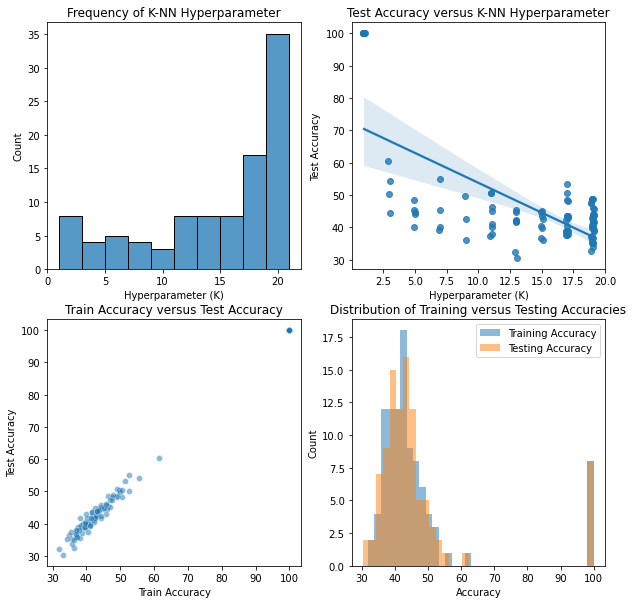

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(data=data, x='parameters', bins=range(1,22,2), ax=axes[0,0]).set(
    title = 'Frequency of K-NN Hyperparameter',
    xlabel = 'Hyperparameter (K)',
    ylabel = 'Count');
sns.scatterplot(data=data, x='train_accuracy', y='test_accuracy', alpha=0.5, ax=axes[1,0]).set(
    title = 'Train Accuracy versus Test Accuracy',
    xlabel = 'Train Accuracy',
    ylabel = 'Test Accuracy');
sns.regplot(x="parameters", y="test_accuracy", data=data, x_jitter=0.1, ax=axes[0,1]).set(
    title = 'Test Accuracy versus K-NN Hyperparameter',
    xlabel = 'Hyperparameter (K)',
    ylabel = 'Test Accuracy');

plt.hist(data['train_accuracy'], bins=35, alpha=0.5, label="Training Accuracy")
plt.hist(data['test_accuracy'], bins=35, alpha=0.5, label="Testing Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.title("Distribution of Training versus Testing Accuracies")
plt.legend(loc='upper right');

In [16]:
display(data.mean(), data.median())

train_accuracy    47.047714
test_accuracy     47.000000
parameters        13.660000
dtype: float64

train_accuracy    42.728571
test_accuracy     42.600000
parameters        17.000000
dtype: float64

From 100 iterations of random testing, we can see that the average testing accuracy is ~47% with an average k value of 13-14. We can also see that, on average, training accuracy and testing accuracy has a relatively linear relationship, indicating that the difference between our initial testing and training accuracies may be due to random chance.

Interestingly enough, some of these random iterations concluded that the best fit model was a k of 1, resulting in both 100% training and testing accuracy. Looking instead at the median of this data as it is more resiliant against outliers results in a testing accuracy of ~42.6% with a parameter of 17.

In [17]:
print(classification_report(y_test_hat, y_test))

                      precision    recall  f1-score   support

             cannoli       0.65      0.46      0.54       422
             churros       0.20      0.62      0.30        96
           foie_gras       0.47      0.60      0.53       235
pulled_pork_sandwich       0.16      0.84      0.27        57
 spaghetti_carbonara       0.91      0.39      0.55       690

            accuracy                           0.48      1500
           macro avg       0.48      0.59      0.44      1500
        weighted avg       0.69      0.48      0.52      1500



Looking back at our initial KNN model and our five randomly chosen categories, we can conclude that our best food categories were `cannoli` and `spaghetti_carbonara`. From our results of multiple iterations of KNN trained on different groups of food categories, we could see that, when introduced to unseen training data, on average, the models saw relatively similar training and testing accuracies. When it comes to image data, KNN seems to perform better when classifying fewer groups. Though our models still performed relatively well when training on images with large variaton between individual images.

Though our model performed relatively well, it is not ideal for real world use due to the extremely high dimensionality of image data as well as the runtime of testing newly introduced data against all other datapoints. The low precision of many of our classes also leads us to believe that, when classifying images into multiple categories, KNN tends to overfit to one particular class, leading to more predictions for that particular class and a higher false positive rate.

In [18]:
def printConfusion(df, index):
    fig, axes = plt.subplots(2, 3)
    fig.suptitle('Confusion Matrices for Overall and Individual Categories')
    axes[0,0].title.set_text(df['category0'].iloc[index])
    sns.heatmap(df['cf0'].iloc[index], fmt="d", annot=True, ax=axes[0, 0], cmap='coolwarm')
    axes[0,1].title.set_text(df['category1'].iloc[index])
    sns.heatmap(df['cf1'].iloc[index], fmt="d", annot=True, ax=axes[0, 1], cmap='coolwarm')
    axes[0,2].title.set_text(df['category2'].iloc[index])
    sns.heatmap(df['cf2'].iloc[index], fmt="d", annot=True, ax=axes[0, 2], cmap='coolwarm')
    axes[1,0].title.set_text(df['category3'].iloc[index])
    sns.heatmap(df['cf3'].iloc[index], fmt="d", annot=True, ax=axes[1, 0], cmap='coolwarm')
    axes[1,1].title.set_text(df['category4'].iloc[index])
    sns.heatmap(df['cf4'].iloc[index], fmt="d", annot=True, ax=axes[1, 1], cmap='coolwarm')
    axes[1,2].title.set_text('Overall Confusion Matrix')
    sns.heatmap(df['confusionMatrix'].iloc[index], fmt="d", annot=True, ax=axes[1,2], cmap='coolwarm')
    fig.set_figheight(9)
    fig.set_figwidth(15)
    
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel("\nActual Values")
    plt.ylabel("Predicted Values")

In [19]:
# printConfusion(data, 99)

In [20]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [21]:
ran = widgets.IntSlider(min=0, max=99, step=1, value=0)
interact(printConfusion, df=fixed(data), index=list(range(100)));

interactive(children=(Dropdown(description='index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…